In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [4]:
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

# Lowest order $C_L$s without Limber approximaton 

### 1) $C_L^{\phi\phi}$



In [75]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


begin=time.time()

chi1fac0 = (lensing_kernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb))
chi1fac0 = chi1fac0 *(r2d*chi_cmb)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (lensing_kernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1./t2d*chi_cmb))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I0_ltrc[ii])

Cl  = 2**2*chi_cmb * result*1./np.pi**2/2.*prefac**2/4. #factor 2 for every phi = -2 int W psi
#factor of 1/2 for every gaussian quadrature

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.3481574058532715


In [76]:
# loading CLASS results for comparison
ll,clpp = np.load('../output/clpp_class_no_limber.npy')

(2, 2000)

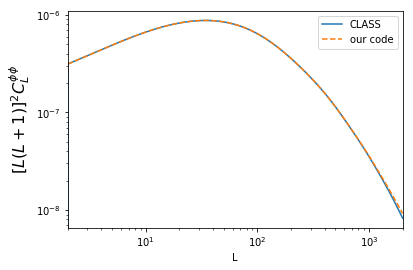

In [77]:
plt.loglog(ll,(ll*(ll+1))**2*clpp, label='CLASS')
plt.loglog(ell_,(ell_*(ell_+1))**2*Cl,ls='--',label='our code')
plt.legend()
plt.ylabel('$[L(L+1)]^2 C_L^{\phi\phi}$',fontsize=16)
plt.xlabel('L')
plt.xlim(2,2000)

In [101]:
mean = 3.
width = 0.5

# uncomment to run new combinations of mean and variance
# so far we have 3, 0.5 and 1, 0.2

# from classy import Class
# cosmo = Class()


# #cosmo_dict.pop('z_cmb')
# cosmo_dict['output']='nCl, lCl, tCl, sCl, mPk'
# cosmo_dict['lensing']='yes'
# cosmo_dict['selection']='gaussian'
# cosmo_dict['selection']='gaussian'
# cosmo_dict['selection_mean'] = str(mean)
# cosmo_dict['selection_width'] = str(width)
# cosmo_dict['l_switch_limber']=100
# cosmo_dict['perturb_sampling_stepsize']=0.01
# cosmo_dict['P_k_max_1/Mpc']=10.

# cosmo.empty()
# cosmo.set(cosmo_dict)
# cosmo.compute()

# cldd = cosmo.density_cl(300)
# clgg = cldd['dd'][0]
# ll_  = cldd['ell']
# np.save('../output/class_clgg_no_limber_Gauss_mean%d_width%0.e.npy'%(mean,width),[ll_,clgg])

In [108]:

ll_,clgg = np.load('../output/class_clgg_no_limber_Gauss_mean%d_width%0.e.npy'%(mean,width))
print('loaded ','../output/class_clgg_post_limber_Gauss_mean%d_width%0.e.npy'%(mean,width))


loaded  ../output/class_clgg_post_limber_Gauss_mean3_width5e-01.npy


### 2) $C_L^{gg}$

In [138]:
# first let's define different redshift kernels

# 1) general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel

import pickle

# 2) prospective LSST kernels
def dNdz_LSST(bin_num,dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'):
    if bin_num is "all":
        zbin, nbin = pickle.load(open(dn_filename+'tot_extrapolated.pkl', encoding='iso-8859-1'))
        norm                = simps(nbin,zbin)
        mbin                = 'None'
    else:
        bins,big_grid,res   = pickle.load(open(dn_filename+'_extrapolated.pkl', encoding='iso-8859-1'))
        mbin                = bins[bin_num]
        zbin                = big_grid
        nbin                = res[bin_num]
        norm                = simps(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print('using z-bin', mbin, 'norm', norm)
    return dndz



def gal_clus(dNdz,b,bin_num):
    """
    dNdz: function returning function dndz for gicen bin number 
    b: function returning bias as function of z 
    bin_num: bin_number (either 'all' or 0-5)
    """
    p_z=dNdz(bin_num)
    def kernel(x,z,chimax=None):
        return b(z)*p_z(z)*dz_dchi(z)

    return kernel

def simple_bias(z):
    return (1.+z)

def constant_bias(z,b=1.):
    return b

In [132]:
#Gaussian test case and comparison to class result
begin=time.time()
kernel1 = gal_kernel(Gauss_redshift(mean,width))
kernel2 = gal_kernel(Gauss_redshift(mean,width))

chimax = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.5635292530059814


(2, 300)

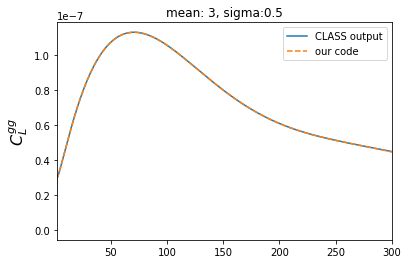

In [117]:
plt.plot(ll_,clgg,label ='CLASS output')
plt.plot(ell_,Clgg,ls='--', label='our code')
plt.legend()
plt.ylabel('$C_L^{gg}$',fontsize=16)
plt.title('mean: %d, sigma:%.1f'%(mean,width))
plt.xlim(2,300)

In [139]:
# now let's use LSST kernels
begin=time.time()
kernel1 = gal_clus(dNdz_LSST,constant_bias,'0')
kernel2 = gal_clus(dNdz_LSST,constant_bias,'all')

chimax = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

print('Time taken = ', time.time()-begin)

TypeError: a bytes-like object is required, not 'str'

# Integrals

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


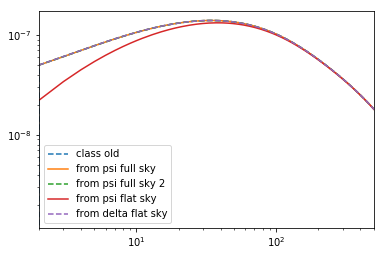

In [26]:

plt.figure()
#full sky
plt.loglog(ll,(ll*(ll+1.))**2*clpp/(2.*np.pi),ls='--',label='class old')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi),label='from psi full sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi),label='from psi full sky 2', ls ='--')
#flat sky
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]))**2*Cl2[:lmax]/(2.*np.pi),label='from psi flat sky')
plt.loglog(ell_[:lmax],Clkk[:lmax]/(2.*np.pi),ls='--',label='from delta flat sky')
plt.legend()
plt.xlim(2,500)
plt.show()

# difference to full sky is not as bad as to flat sky (this is also noted in the Kilbinger (Kitching?) paper for the Limber approximation)
plt.figure()
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi),label='from psi full sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi),label='from psi full sky 2')
plt.loglog(ll,(ll*(ll+1.))**2*clpp/(2.*np.pi),ls='--', label='class old*4')
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp'])/(2.*np.pi),ls=':',label='class new *4')
plt.loglog(ell_[:lmax],Clkk[:lmax]/(2.*np.pi),ls='--',label='from delta flat sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]))**2*Cl2[:lmax]/(2.*np.pi),label='from psi flat sky')
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl3[:lmax]/(2.*np.pi))
plt.xlim(2,500)
plt.legend()
plt.show()

In [55]:
# general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel

#third kernel
###################################
begin=time.time()
kernel1 = gal_kernel(Gauss_redshift(mean,width))
kernel2 = gal_kernel(Gauss_redshift(mean,width))

chimax = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg_c = chimax * result/np.pi**2/2.

print('Time taken = ', time.time()-begin)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4085056781768799


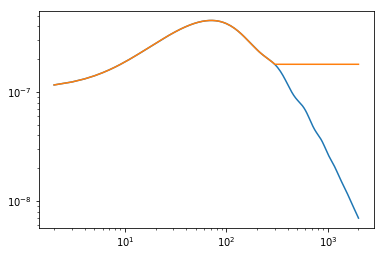

In [57]:

plt.loglog(ell_, Clgg_c)
plt.loglog(ell_,np.interp(ell_,cldd['ell'],cldd['dd'][0])*4.)

(0, 1.1)

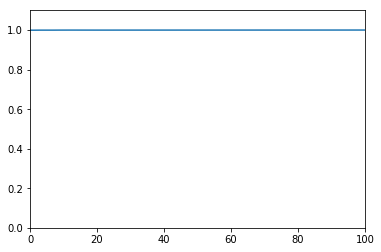

In [31]:
print(1./(np.interp(ell_,cldd['ell'],cldd['dd'][0])/Clgg_c))

[4.00065118 4.00164096 4.00029088 4.0003037  4.00060303 3.99944659
 3.99999536 4.00015801 3.99927358 3.99948015 4.00004037 3.99959779
 3.99908251 3.99941173 3.99986982 3.9996601  3.9991432  3.99905191
 3.99943869 3.99974798 3.9996024  3.99917061 3.99888759 3.99898055
 3.99931073 3.99956077 3.99952429 3.99923706 3.99890917 3.99875264
 3.99884442 3.99910543 3.99937243 3.9994995  3.99943031 3.99921071
 3.99895039 3.99876458 3.99872463 3.99883601 3.99904544 3.99926989
 3.99942994 3.99947626 3.99940205 3.99923794 3.99903742 3.99885816
 3.99874544 3.99872259 3.99878755 3.99891635 3.99907209 3.99921543
 3.99931442 3.99935005 3.99931835 3.99922941 3.99910371 3.99896677
 3.99884472 3.99875878 3.99872216 3.99873804 3.99880062 3.99889692
 3.99900978 3.99912181 3.9992171  3.9992833  3.9993131  3.99930441
 3.99926062 3.99918881 3.99909913 3.99900411 3.99891596 3.99884506
 3.99879897 3.9987815  3.9987928  3.99882982 3.99888683 3.99895725
 3.99903363 3.99910831 3.99917393 3.99922387 3.9992541  3.9992

# Cross Correlations

computing $C_L^{\kappa g}$ in post Limber and compare to Limber results

In [32]:
# set up (as before), but using FFTlog of P_deltapsi

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel
kernel2  = gal_kernel(Gauss_redshift(mean,width))

n = 2

begin=time.time()



chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I2_ltrc[ii])
    

Cl_kg = chimax * result*1./np.pi**2/2.*prefac

print('Time taken = ', time.time()-begin)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4936785697937012


<function matplotlib.pyplot.loglog(*args, **kwargs)>

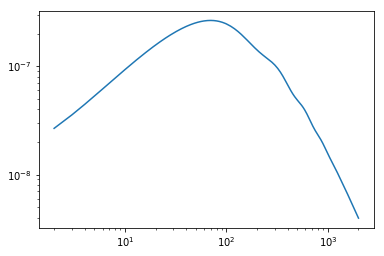

In [33]:
plt.loglog(ell_[:lmax],ell_[:lmax]*(ell_[:lmax]+1.)*Cl_kg[:lmax])
#plt.loglog(ll,clpp,ls='--', label='class old*4')
plt.loglog

In [34]:
# cross in Limber
chis = np.linspace(1.,chi_cmb,5000) #in Mpc/h
ells = np.linspace(1,2000,200)
result=[]
for l_ in ells:
    integrand=[]
    for chi in chis:
        k = l_/chi #in h/Mpc
        try:
            Pk= cosmo.pk(k*h,0.)*D_chi(chi)**2*h**3
        except:
            Pk= 0.
        integrand+=[lensing_kernel(chi,chi_cmb)*kernel2(chi)*Pk]
    result+=[np.trapz(integrand, chis)]
clkg=np.asarray(result)*prefac

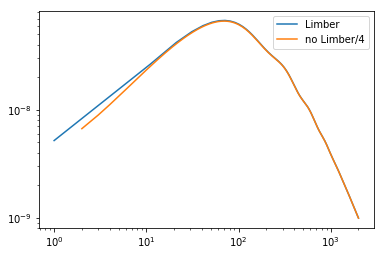

In [35]:
#same factor of four as before, disagreement at low ell is expected
plt.loglog(ells,clkg*(ells+1.)/ells,label='Limber')
plt.loglog(ell_[:lmax],ell_[:lmax]*(ell_[:lmax]+1.)*Cl_kg[:lmax]/4.,label='no Limber/4')
plt.legend()

In [36]:
# set up (as before), but using FFTlog of P_deltadelta, i.e. lensing kernel 2, should give better match to no Limber, also we should recover factor 0f 4

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel_2
kernel2  = gal_kernel(Gauss_redshift(mean,width))

n = 4

begin=time.time()



chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])
    

Cl_kg2 = chimax * result*1./np.pi**2/2.*prefac

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.5367660522460938


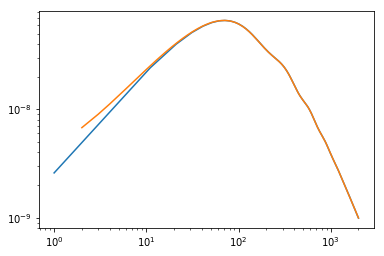

In [37]:
plt.loglog(ells,clkg,label='Limber')
plt.loglog(ell_[:lmax],Cl_kg2[:lmax]/4.,label='no Limber')

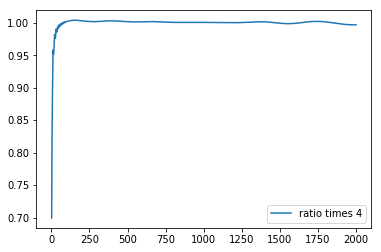

In [38]:
plt.plot(ell_[:lmax],np.interp(ell_[:lmax],ells,clkg)/Cl_kg2[:lmax]*4,label='ratio times 4')
plt.legend()

# Cls on grids for post Born integrals

### $C_L^{\phi\phi}(\chi,\chi')$ (appears eg. in Eqs. (4.2))

In [39]:
# this is the factor that input files seem to be offsetted by
fudge = 0.25

In [40]:
def phi_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))

#### for $\chi_{max}=\chi_{CMB}$

In [41]:
# this is Chirags version, which loops over the inner integral 
chimax = chi_cmb
chi1s  = t_*chimax

chi1fac0 = phi_kernel(chi1s, chimax)

t2d      = t_.reshape(1, -1, 1)
#get rid of r -axis
I0_ltc   = np.squeeze(I0_ltrc)

begin = time.time()
result = []

#outer chis
for ii, chi in enumerate(chi1s):
    
    chifac    = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop
    
    chi2fac00 = (phi_kernel(t2d*chi, chimax)*D_chi(t2d*chi))
    chi2fac01 = (phi_kernel(1./t2d*chi, chimax)*D_chi(1./t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01
    fac       = w1.reshape(1, -1, 1)*chi2fac0*chifac
    integrand = fac * I0_ltc
    
    result.append(integrand.sum(axis = 2))

result = np.swapaxes(np.array(result),0,1)

result = (result*chi1fac0.reshape(1, -1, 1)*w1.reshape(1,-1, 1))*chimax/np.pi**2/2.*prefac**2
print(result.shape)
Cl2      = result.sum(axis=(1,2))

print('Time taken = ', time.time()-begin)

(289, 100, 100)
Time taken =  4.88441801071167


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


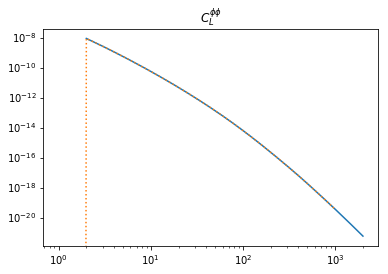

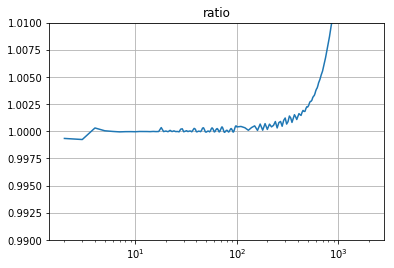

In [42]:
# make test plot
plt.title('$C_L^{\phi\phi}$')
plt.loglog(ell_,Cl2, label = 'our result, post Limber')
plt.loglog(ll,np.interp(ll,cllen['ell'],cllen['pp']),ls=':',label='class, post Limber')
plt.show()

plt.title('ratio')
plt.semilogx(ell_,Cl2/np.interp(ell_,cllen['ell'],cllen['pp']))
plt.ylim(0.99,1.01)
plt.grid()
plt.show()

sub-percent accuracy down to L=800 (I have canceled factor of 2 in $\phi=2\int...$ and fudge factor, and dont code them)

but we don't need the split as it is in cell 103! We want to loop over the upper integration boundary.

#### now with varying $\chi_{max}$ for Eq. (4.2)

In [43]:
# test case for expanding by first chimax axis, multiply time by 100 to get total time for varying both integration boundaries
chi1s = np.ones(100)*chi_cmb #for real case replace this by t_*chi_cmb
r2d, t2d, chimax1 = np.meshgrid(t_,t_,chi1s)
w11, w12, _ = np.meshgrid(w1,w1,chi1s)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
chimax1 = np.expand_dims(chimax1,2)
I0_ltrcx = np.expand_dims(I0_ltrc,5)


print(chimax1.shape)

#chi_max1=chi_cmb #maximum for r*chi
chi_max2=chi_cmb #maximum for t*chi

begin=time.time()

#Cl = np.zeros((ell_.size,100,100))

# for ii, chi_max1 in enumerate(chi1s):
#     print(ii)
#     for jj, chi_max2 in enumerate(chi1s):
chi1fac0 = (lensing_kernel(r2d*chi1s, chi1s)*D_chi(r2d*chi1s))
chi1fac0 = chi1fac0 *(r2d*chi1s)**(1-nu_n_.reshape(1, 1, -1, 1))

#print(r2d.shape,chimax1.shape,lensing_kernel(r2d*chi_max1, chi_max1).shape)

chi2fac00 = (lensing_kernel(t2d*r2d*chi_max2, chi_max2)*D_chi(r2d*t2d*chi_max2))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_max2, chi_max2)*D_chi(r2d*1./t2d*chi_max2))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1,1)-2)
chi2fac0  = chi2fac00 + chi2fac01
del chi2fac00
del chi2fac01
chifacs   = w11*w12*chi1fac0* chi2fac0

# print(chifacs.shape)
Cl =[]
lmax = ell_.size
for nn  in range(20):    
    print(nn)
    Cl+=[np.sum(chifacs*I0_ltrcx[nn],axis=(0,1,2))*chi1s *1./np.pi**2*prefac**2/2.]

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


(100, 100, 1, 100)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Time taken =  54.6534526348114


In [44]:
Cl = np.asarray(Cl)
Cl.shape


(20, 100)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


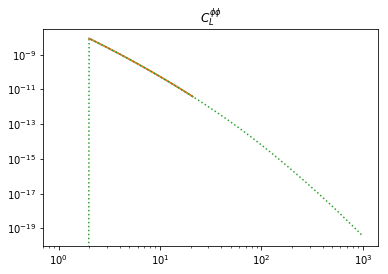

In [45]:
# make test plot
plt.title('$C_L^{\phi\phi}$')
plt.loglog(ell_[0:20],Cl[:,0], label = 'our result, post Limber')

plt.loglog(ell_[0:20],Cl[:,-1], label = 'our result, post Limber 2')

plt.loglog(ll,np.interp(ll,cllen['ell'],cllen['pp']),ls=':',label='class, post Limber')
plt.show()

### 

# Starting Vanessa's implementation of $G^{ab}$s

### 1) $ G_l^{\phi\psi}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\psi}(\chi_1,\chi_2)$ 
$= \mathcal{A}^2 \frac{1}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} [1+z(\chi_2)] D(\chi_2) I_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{\nu_n-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

needs to be evaluated for varying $\chi_{max}$ and $\chi_2$ (this appears in Eq. 4.2).

replacing $\chi_2$ by $r\chi_{max}$ allows doing basically the same as before, just without summing over $r$,
so that the ouput for fixed $\chi_{max}$ has shape of $r$.
Then we only need one loop over $\chi_{max}$.

In [46]:
import time
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) #* (1.+z_chi(xi))

chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
#I0_ltrc  = np.swapaxes(I0_lcrt, 1, 3)

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi1_max)):
    if jj%10==0:
        print(jj)
    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max)*lensing_kernel(r2d*t2d*chi2_max, chi1_max)))
    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))
    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = chi1fac0* chi2fac0*w12

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    Cl[jj]=result*1./np.pi**2*prefac**2/2./2. #divide by another factor of 2 because of Gaussian quadrature

# swap axes to have cl_phipsi_l(chi_max,chi)
Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  144.70273280143738


to get $C_l^{\phi\phi}(\chi_1,\chi_2)$ we only need to do one more looped integral:

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})= \int_0^{\chi_{max2}} \mathrm{d}\chi_2  W(\chi_2,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_2)$

with loop over $\chi_{max2}$

with parametrization by $r$ and Gaussian quadrature this becomes

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})=\chi_{max2} \int_0^{1} \mathrm{d} r  W(\chi_{max2} r ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r)= \chi_{max2} / 2 \sum_{r_{i}} w_i W(\chi_{max2} r_{i} ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r_{i})$

In [47]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
w11, w12 = np.meshgrid(w1,w1)
r2d, t2d = np.meshgrid(t_,t_)
chi2_max = chi_cmb
result = np.zeros((len(t_),len(ell_),len(t_)))
for jj, chi2_max in enumerate((chi2_max*t_)):

    result[jj] = chi2_max/2.*np.sum(w11*Cl*lensing_kernel((chi2_max*r2d),chi2_max), axis=2) #should work according to numpy broadcasting ruler
result=result.swapaxes(0,1)

np.save('../G_matrices/clphiphi',result)

(1, 2000)

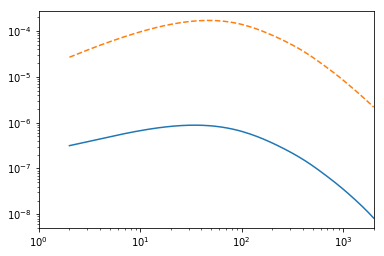

In [48]:
#lets check if we get the correct result when we look at the last entry where chi_max=chi_cmb
clphiphi = result[:,-1,-1]
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*clphiphi,ls='--')
plt.loglog()
plt.xlim(1,2000)
#--> not working yet 

### tesing gaussian quadrature with simple integral test
$\int_0^1 \mathrm{d} x x^2 = 1/2 \sum_i w_i t_i^2 = 1/3 $

In [49]:
0.5*np.sum(w1*t_**2)

0.33333333387229197

In [50]:
# loading Chirags results
clphiphi2 = np.zeros((len(t_),len(ell_),len(t_)))
path = '../scripts/output/clphiphi/'
for ii in range(len(t_)):
    clphiphi2[ii] = np.loadtxt(path+'%d.txt'%ii)[:,1:]
clphiphi2=np.swapaxes(clphiphi2,0,1)

In [51]:
clphiphi2_ = clphiphi2[:,-1,-1]

(1, 2000)

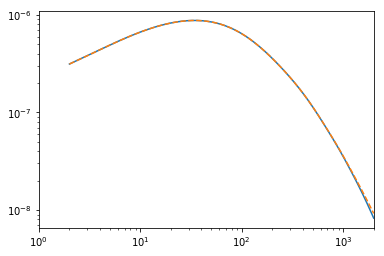

In [52]:
# Chirags results match Class perfectly at chi_max=chi_cmb
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*clphiphi2_,ls='--')
plt.loglog()
plt.xlim(1,2000)

In [53]:
#copying Clphipsi calculation and changing it back to clphiphi with one varying upper bound
# the only changes are:
# 1) adding a lensing kernel to chi1fac0
# 2) multiplying by w11
# 3) summing over all axes 

import time
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) #* (1.+z_chi(xi))

chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
#I0_ltrc  = np.swapaxes(I0_lcrt, 1, 3)

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)

    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chi1_max))
    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))
    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0#*w11

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    Cl[jj] = result*1./np.pi**2*prefac**2/2.
# swap axes to have cl_phipsi_l(chi_max,chi)

Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  143.62226152420044


In [54]:
#doing summation later is ok
#taking lensing kernel out is okay
#taking weight out is okay
#adding loop over outer in above cell is okay
#adding loop over outer here is okay

result = np.zeros((len(t_),len(ell_),len(t_)))

for jj, chimax in enumerate(t_*chi_cmb):
    test   = np.zeros((len(ell_),len(t_)))
    for ii  in range(ell_.size): 
        test[ii] = chimax*np.sum(Cl[ii,:,:]*lensing_kernel(t_*chimax, chimax)*w1, axis=-1)
    result[jj] = test
result = np.swapaxes(result,0,1)

(1, 2000)

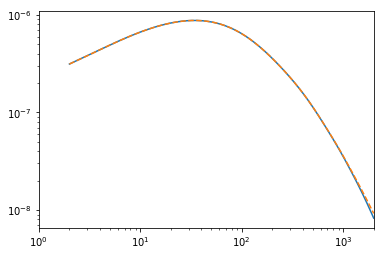

In [55]:
# this works again beautifully (some fudge factor still seems to be off, but okay)
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*result[:,-1,-1],ls='--')
plt.loglog()
plt.xlim(1,2000)
# so I would expect that if I do steps 1-3 in post processing that this should work also! (but it doesnt)
# ergo: there must be a bug somewhere or my thinking is wrong

In [60]:
print(np.allclose(clphiphi2,result))
np.save('../G_matrices/clphiphi',result)

True


<class 'dict'>


In [23]:
import json
import numpy as np
out={}
np.save('../output/clpp_class_no_limber',[cllen['ell'],cllen['pp']])


<class 'dict'>


TypeError: Object of type 'ndarray' is not JSON serializable